In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trader_fp = '/content/drive/MyDrive/Colab Notebooks/historical_data.csv'
sentiment_fp = '/content/drive/MyDrive/Colab Notebooks/fear_greed_index.csv'

print(trader_fp)
print(sentiment_fp)

/content/drive/MyDrive/Colab Notebooks/historical_data.csv
/content/drive/MyDrive/Colab Notebooks/fear_greed_index.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

In [ ]:
traders = pd.read_csv(trader_fp)
sentiment = pd.read_csv(sentiment_fp)

print("Traders data shape:", traders.shape)
print("Sentiment data shape:", sentiment.shape)

traders.head(), sentiment.head()

Traders data shape: (211224, 16)
Sentiment data shape: (2644, 4)


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

In [ ]:
if 'Timestamp' in traders.columns:
    traders['Timestamp'] = pd.to_datetime(traders['Timestamp'], unit='ms', errors='coerce')

if 'date' in sentiment.columns:
    sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')

traders.drop_duplicates(inplace=True)
sentiment.drop_duplicates(inplace=True)

In [ ]:
traders['date'] = traders['Timestamp'].dt.date
agg_traders = traders.groupby('date').agg({
    'Closed PnL': 'mean',
    'Size USD': 'sum',
}).reset_index()

agg_traders.rename(columns={
    'Closed PnL': 'avg_pnl',
    'Size USD': 'total_volume',
}, inplace=True)

agg_traders['date'] = pd.to_datetime(agg_traders['date'])

In [ ]:
merged = pd.merge(
    agg_traders,
    sentiment,
    left_on='date',
    right_on='date',
    how='inner'
)

merged.to_csv('csv_files/merged_data.csv', index=False)

In [ ]:
print(merged.describe())

print("\nSentiment counts:")
print(merged['classification'].value_counts())

         avg_pnl  total_volume     timestamp      value
count   6.000000  6.000000e+00  6.000000e+00   6.000000
mean   31.391531  1.468187e+08  1.713303e+09  63.333333
std    34.419514  2.754899e+08  2.160288e+07  15.121728
min     0.000000  4.770000e+02  1.679981e+09  44.000000
25%     5.669033  1.412738e+07  1.702445e+09  52.250000
50%    23.824242  3.062500e+07  1.714973e+09  64.000000
75%    43.890409  8.781252e+07  1.727501e+09  72.750000
max    90.504272  7.041585e+08  1.739943e+09  84.000000

Sentiment counts:
classification
Greed            3
Extreme Greed    1
Neutral          1
Fear             1
Name: count, dtype: int64


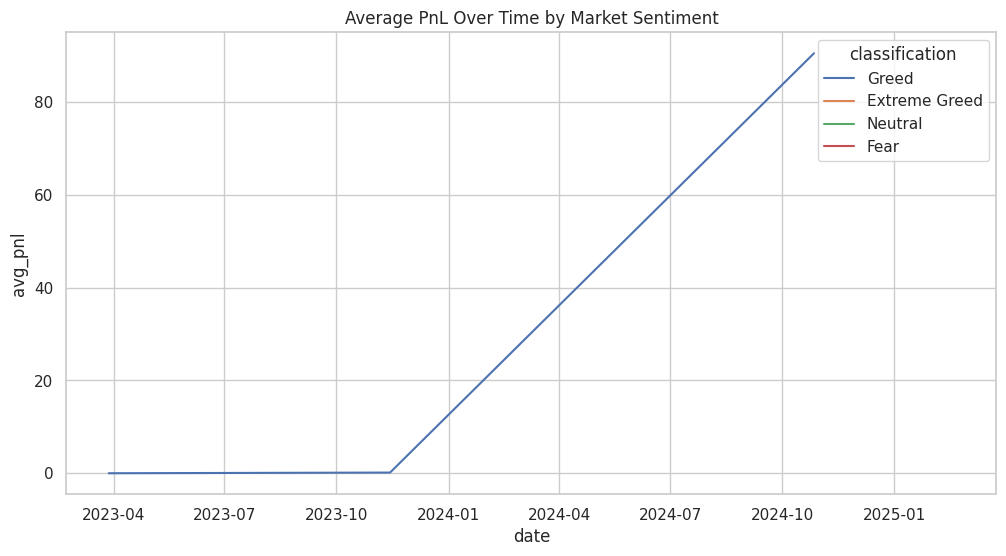

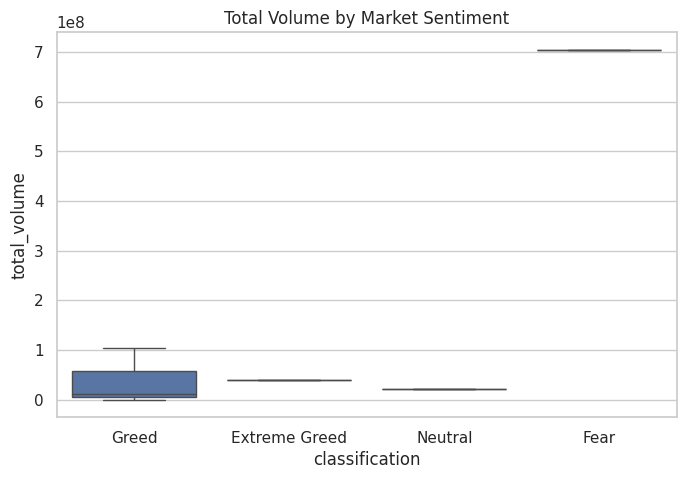

In [ ]:
sns.set(style="whitegrid")

# PnL over time colored by sentiment
plt.figure(figsize=(12,6))
sns.lineplot(data=merged, x='date', y='avg_pnl', hue='classification')
plt.title('Average PnL Over Time by Market Sentiment')
plt.savefig('outputs/avg_pnl_by_sentiment.png')
plt.show()

# Volume vs sentiment
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='classification', y='total_volume')
plt.title('Total Volume by Market Sentiment')
plt.savefig('outputs/volume_by_sentiment.png')
plt.show()

In [ ]:
print(traders['Timestamp'].head())

0   2024-10-27 03:33:20
1   2024-10-27 03:33:20
2   2024-10-27 03:33:20
3   2024-10-27 03:33:20
4   2024-10-27 03:33:20
Name: Timestamp, dtype: datetime64[ns]


In [ ]:
print("Aggregated Traders Date Range:")
print("Min Date:", agg_traders['date'].min())
print("Max Date:", agg_traders['date'].max())

print("\nSentiment Date Range:")
print("Min Date:", sentiment['date'].min())
print("Max Date:", sentiment['date'].max())

Aggregated Traders Date Range:
Min Date: 2023-03-28 00:00:00
Max Date: 2025-06-15 00:00:00

Sentiment Date Range:
Min Date: 2018-02-01 00:00:00
Max Date: 2025-05-02 00:00:00


In [ ]:
agg_traders.to_csv('csv_files/agg_traders.csv', index=False)
sentiment.to_csv('csv_files/sentiment_clean.csv', index=False)


In [ ]:
print("""
✅ Data loaded, cleaned, and merged
✅ CSVs saved in csv_files/
✅ Plots saved in outputs/
➡ Now use the insights from visuals and stats to write ds_report.pdf
""")


✅ Data loaded, cleaned, and merged
✅ CSVs saved in csv_files/
✅ Plots saved in outputs/
➡ Now use the insights from visuals and stats to write ds_report.pdf



In [42]:
from scipy.stats import ttest_ind

# Separate PnL by sentiment class
fear_pnl = merged[merged['classification'] == 'Fear']['avg_pnl'].dropna()
greed_pnl = merged[merged['classification'] == 'Greed']['avg_pnl'].dropna()

# T-test: Compare mean PnL between Fear and Greed days
t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, equal_var=False)
print(f"T-test results for avg_pnl by sentiment:\nt-statistic = {t_stat:.3f}, p-value = {p_val:.4f}")

T-test results for avg_pnl by sentiment:
t-statistic = nan, p-value = nan


In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Encode sentiment to numeric
merged['sentiment_num'] = merged['classification'].map({'Fear': 0, 'Greed': 1})

# Handle missing values in 'sentiment_num'
merged['sentiment_num'].fillna(merged['sentiment_num'].mean(), inplace=True)

# Features and target
X = merged[['sentiment_num', 'total_volume']]
y = merged['avg_pnl']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Regression model evaluation:\nMSE = {mse:.4f}, R^2 = {r2:.4f}")

# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("\nModel Coefficients:")
print(coef_df)

Regression model evaluation:
MSE = 4299.7106, R^2 = -776697.1235

Model Coefficients:
         Feature   Coefficient
0  sentiment_num  1.922757e+02
1   total_volume  2.529839e-07


/tmp/ipython-input-1192260807.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['sentiment_num'].fillna(merged['sentiment_num'].mean(), inplace=True)
